In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import nltk
nltk.download('stopwords')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:

fake=pd.read_csv('psi_3571_reconhecedor/Fake.Br Corpus/full_texts/fake.csv')

In [11]:
true=pd.read_csv('psi_3571_reconhecedor/Fake.Br Corpus/full_texts/true.csv')

In [12]:
true['category'] = 1
fake['category'] = 0

In [13]:
df=pd.concat([true,fake])

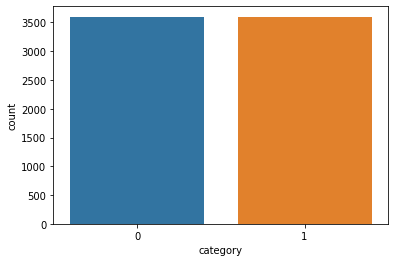

In [14]:
sns.countplot(df['category'])

In [24]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [25]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

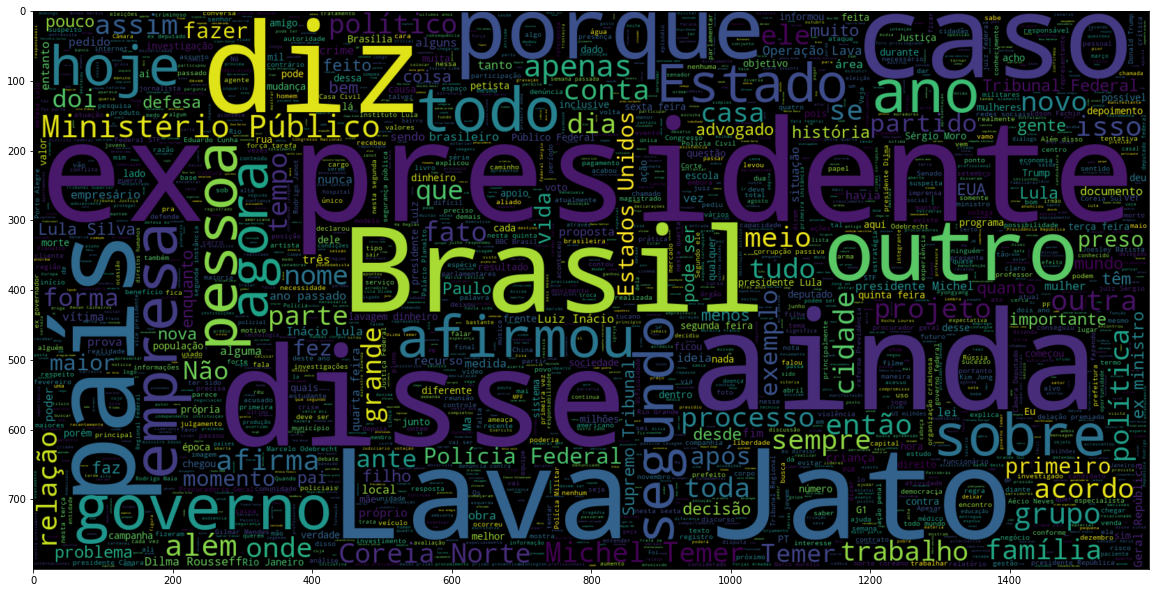

In [26]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

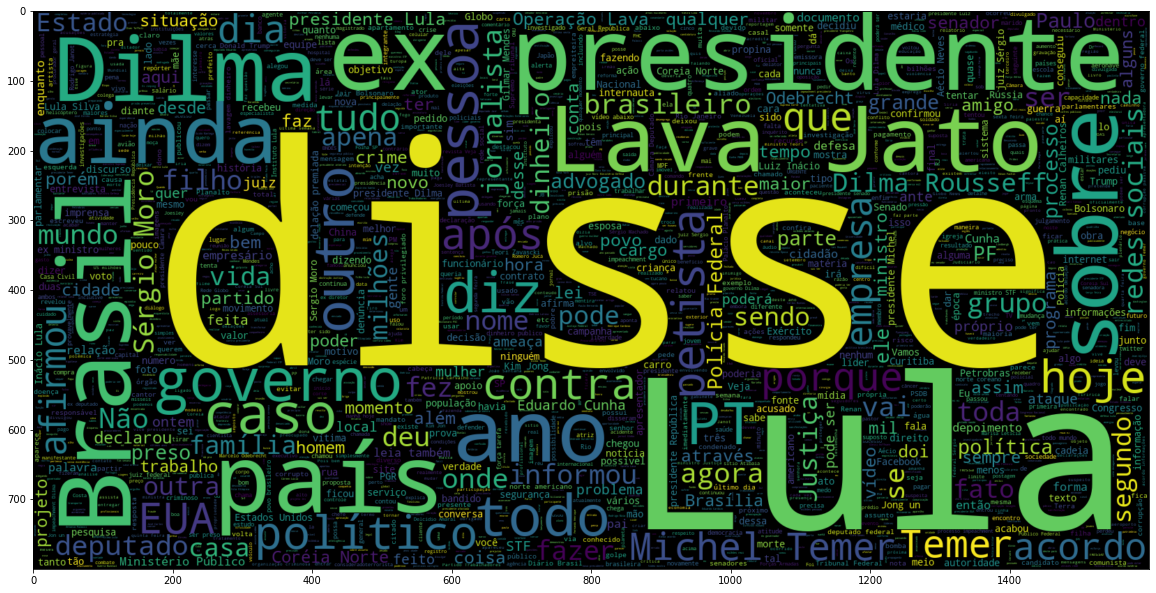

In [27]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [28]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [29]:
max_features = 10000
maxlen = 300

In [30]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [31]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [41]:
EMBEDDING_FILE = open('glove_s100.txt', encoding='cp437')

In [43]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in EMBEDDING_FILE)

In [45]:

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [46]:
batch_size = 256
epochs = 10
embed_size = 100

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [48]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [50]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Train on 5400 samples, validate on 1800 samples
Epoch 1/10
5400/5400 [==============================] - 48s 9ms/step - loss: 0.6789 - accuracy: 0.5859 - val_loss: 0.6930 - val_accuracy: 0.5250
Epoch 2/10
5400/5400 [==============================] - 48s 9ms/step - loss: 0.6898 - accuracy: 0.5309 - val_loss: 0.6764 - val_accuracy: 0.6356
Epoch 3/10
5400/5400 [==============================] - 53s 10ms/step - loss: 0.6119 - accuracy: 0.6572 - val_loss: 0.2695 - val_accuracy: 0.9117
Epoch 4/10
5400/5400 [==============================] - 54s 10ms/step - loss: 0.2365 - accuracy: 0.9272 - val_loss: 0.1790 - val_accuracy: 0.9394
Epoch 5/10
5400/5400 [==============================] - 57s 10ms/step - loss: 0.1653 - accuracy: 0.9480 - val_loss: 0.1703 - val_accuracy: 0.9444
Epoch 6/10
5400/5400 [==============================] - 59s 11ms/step - loss: 0.1613 - accuracy: 0.9476 - val_loss: 0.1745 - val_accuracy: 0.9406
Epoch 7/10
5400/5400 [========

In [51]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

5400/5400 [==============================] - 24s 4ms/step
Accuracy of the model on Training Data is -  95.48147916793823
1800/1800 [==============================] - 8s 4ms/step
Accuracy of the model on Testing Data is -  94.22222375869751


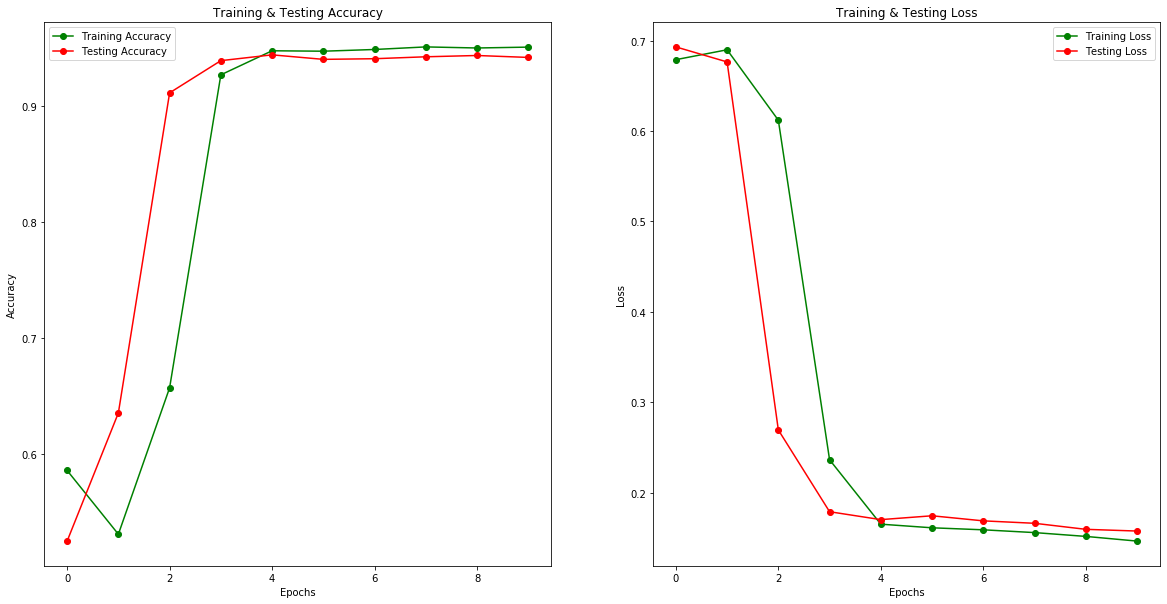

In [52]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [53]:
pred = model.predict_classes(X_test)
pred[:5]

array([[1],
       [1],
       [0],
       [1],
       [0]])

In [54]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.94      0.95      0.94       900
    Not Fake       0.95      0.94      0.94       900

   micro avg       0.94      0.94      0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



In [55]:
cm = confusion_matrix(y_test,pred)
cm

array([[853,  47],
       [ 57, 843]], dtype=int64)

In [57]:
cm = pd.DataFrame(cm , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])

Text(69.0, 0.5, 'Predicted')

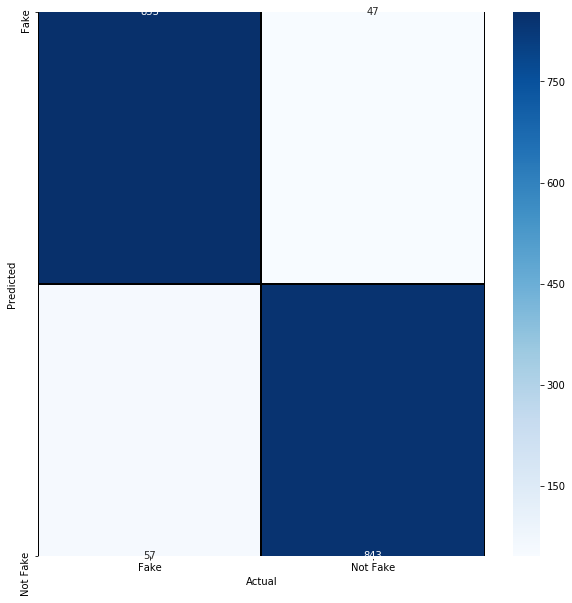

In [58]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")